In [372]:
# Data: http://share.mailcharts.com/0P092V2m0V2x
# Headers: id, company name, company id, subject, sent at, discounts

# Goal 1: When will the next email be?
# -- in [n] seconds
# Goal 2: Will the next email be a discount?
# -- True || False
# Goal 3: How much will they discount by?

In [431]:
from datetime import date, datetime
import pandas as pd
import numpy as np
import re
import scipy
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [374]:
df = pd.read_csv('./data/capstone-sample.csv')
df.shape

(2420, 6)

In [411]:
df[df["company_id"] == 285]

,id,company_name,company_id,subject,sent_at,promotion_type,promo_not_promo,month,year,day,weeknum,am_pm,weekday_weekend,prev_email,prev_email_delta
2419,2535536,Abercrombie & Fitch,285,LAST DAY: Sale up to 40% off & 25% off your pu...,2017-10-23 11:06:10,"[""discount_percentage"", ""discount_percentage"",...",1,10,2017,23,43,0,1,2017-10-23 06:14:29,17501
2418,2534559,Abercrombie & Fitch,285,Another adventure calling your name?,2017-10-23 06:14:29,"[null, null, null, null, null, null, null, nul...",1,10,2017,23,43,0,1,2017-10-22 11:12:19,68530
2414,2529831,Abercrombie & Fitch,285,Even sale is on sale! Get 25% off before it’s ...,2017-10-22 11:12:19,"[""discount_percentage"", ""discount_percentage"",...",1,10,2017,22,42,0,0,2017-10-22 06:33:21,16738
2412,2528702,Abercrombie & Fitch,285,Hollister Sale. Party time. 🎉,2017-10-22 06:33:21,"[""discount_percentage"", ""discount_percentage"",...",1,10,2017,22,42,0,0,2017-10-21 11:08:37,69884
2409,2524519,Abercrombie & Fitch,285,Limited edition styles by artist Ryder Robison…,2017-10-21 11:08:37,"[""discount_percentage"", ""discount_percentage"",...",1,10,2017,21,42,0,0,2017-10-20 11:24:24,85453
2398,2516681,Abercrombie & Fitch,285,Stack 25% off your purchase with ALL these deals…,2017-10-20 11:24:24,"[""discount_percentage"", ""discount_percentage"",...",1,10,2017,20,42,0,1,2017-10-20 11:11:25,779
2397,2516588,Abercrombie & Fitch,285,Stack 25% off your purchase with ALL these deals…,2017-10-20 11:11:25,"[""discount_percentage"", ""discount_percentage"",...",1,10,2017,20,42,0,1,2017-10-20 06:33:19,16686
2396,2515417,Abercrombie & Fitch,285,The hoodie & sweatshirt hype is real.,2017-10-20 06:33:19,"[""discount_percentage"", ""discount_percentage"",...",1,10,2017,20,42,0,1,2017-10-19 13:34:25,61134
2385,2507584,Abercrombie & Fitch,285,Get up to 40% off our favorites + 25% off your...,2017-10-19 13:34:25,"[""discount_percentage"", ""discount_percentage"",...",1,10,2017,19,42,0,1,2017-10-19 06:34:42,25183
2382,2504856,Abercrombie & Fitch,285,"Hey, you. We've got new arrivals ❤",2017-10-19 06:34:42,"[""discount_percentage"", ""discount_percentage"",...",1,10,2017,19,42,0,1,2017-10-18 23:04:06,27036


In [375]:
# Add features

def determine_weekday(n):
    if n == 5 or n == 6:
        # weekend
        return 0
    else:
        #weekday
        return 1
    
def determine_am_pm(date):
    return 0 if date.strftime('%p') == "AM" else 1
    
def create_datetime(row):
    return datetime(row["year"],row["month"],row["day"])

df["promo_not_promo"] = np.where(df["promotion_type"] == "[null]", "0", "1")
df["month"] = df["sent_at"].str.split('-').str.get(1).astype(int)
df["year"] = df["sent_at"].str.split('-').str.get(0).astype(int)
df["day"] = df["sent_at"].str.split('-').str.get(2).str.split(' ').str.get(0).astype(int)
df["weeknum"] = df.apply(lambda x: create_datetime(x).isocalendar()[1], axis=1)
df["am_pm"] = df.apply(lambda x: determine_am_pm(create_datetime(x)), axis=1)
df["weekday_weekend"] = df.apply(lambda x: determine_weekday(create_datetime(x).weekday()), axis=1)

In [376]:
# Get company dummies (we will use this later)

dummy_company = pd.get_dummies(df["company_name"])
dummy_company.head()

,1-800-Flowers.com,1000Bulbs.com,10DollarMall,A'GACI,Abercrombie & Fitch,Ace & Everett,Ace & Tate,Active in Style,Adorama,Advance Auto Parts,Alexis Bittar,AllModern,Allurez
0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0


In [377]:
# Gather when the previous email was sent

df = df.sort_values("sent_at", ascending=False)
results = []
for index, row in df.iterrows():
    company_emails = df[df["company_id"] == row["company_id"]]
    earlier_emails = list(filter(lambda x: x < row["sent_at"], company_emails["sent_at"]))
    if len(earlier_emails) > 0:
        results.append(earlier_emails[0])
        continue
    else:
        results.append(None)

# Save the results to our dataframe
df["prev_email"] = results

In [378]:
# Get the time delta with the last email

def construct_full_date(timestamp):
    # 2017-01-01 00:01:32
    # format: year, month, day, hour, minute, seconds
    date = re.split(" |\-|\:", timestamp)
    _date = [int(x) for x in date]
    return datetime(year=_date[0], month=_date[1], day=_date[2], hour=_date[3], minute=_date[4], second=_date[5])

def get_time_delta(a, b):
    if b == None:
        return 0
    else:
        return (construct_full_date(a) - construct_full_date(b)).seconds
    
df["prev_email_delta"] = df.apply(lambda x: get_time_delta(x["sent_at"], x["prev_email"]), axis=1)
df.head(3)

,id,company_name,company_id,subject,sent_at,promotion_type,promo_not_promo,month,year,day,weeknum,am_pm,weekday_weekend,prev_email,prev_email_delta
2419,2535536,Abercrombie & Fitch,285,LAST DAY: Sale up to 40% off & 25% off your pu...,2017-10-23 11:06:10,"[""discount_percentage"", ""discount_percentage"",...",1,10,2017,23,43,0,1,2017-10-23 06:14:29,17501
2418,2534559,Abercrombie & Fitch,285,Another adventure calling your name?,2017-10-23 06:14:29,"[null, null, null, null, null, null, null, nul...",1,10,2017,23,43,0,1,2017-10-22 11:12:19,68530
2417,2534382,1-800-Flowers.com,88,Surprise Her With 24 Red Roses—Just $29.99!,2017-10-23 04:04:33,"[""discount_percentage"", ""discount_percentage"",...",1,10,2017,23,43,0,1,2017-10-21 04:08:14,86179


In [388]:
# Merge both dataframes

data = pd.merge(df, dummy_company, right_index=True, left_index=True)

In [401]:
data.head()

# Drop the columns we don't need
data = data.drop(["company_name", "promotion_type", "subject", "sent_at", "id"], axis=1)

ValueError: labels ['company_name' 'promotion_type' 'subject' 'sent_at' 'id'] not contained in axis

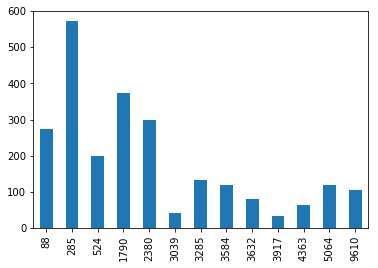

In [427]:
# Visualize the send volume to understand the data a bit better

email_counts_sum = data["company_id"].value_counts().sort_index(axis=0)

email_counts_sum.plot(kind='bar')

In [437]:
# Sum of time in between emails divided by the # of emails

time_delta_sum = data.groupby(by='company_id')["prev_email_delta"].sum()
time_delta_sum / email_counts_sum / 60 / 60  # convert seconds to hours

company_id
88      11.120263
285      9.363537
524     12.296591
1790    10.416479
2380    11.822369
3039     9.561091
3285    11.280178
3584    11.962366
3632    10.478076
3917    11.498492
4363    12.252350
5064     4.029412
9610    11.234772
dtype: float64

In [486]:
time_delta_sum_by_month = data.groupby(by=['company_id', 'month'])["prev_email_delta"].sum()
email_counts_sumby_month = data.groupby(by=['company_id', 'month'])["prev_email_delta"].count()
(time_delta_sum_by_month / email_counts_sumby_month / 60 / 60)
#.plot.bar(stacked=True)
# figure out how to visualize this
# coreplot to see correlation between variables
# scatterplot for the ones with high-correlation
# boxplot by month of companies sending behavior

company_id  month
88          1         9.879040
            2         9.208837
            3        16.880588
            4        12.000613
            5         8.169569
            6        13.335972
            7        13.893099
            8        13.562585
            9         9.819545
            10       12.520833
285         1        10.196737
            2         8.815203
            3         9.547537
            4        10.000491
            5         9.903333
            6        10.039167
            7        10.150443
            8         7.461021
            9         7.999588
            10       10.284087
524         1         9.088889
            2        11.205098
            3        13.601679
            4        11.187447
            5        15.970486
            6        10.606222
            7        15.260518
            8        10.814208
            9        11.264431
            10       13.498021
                       ...    
3917        10       

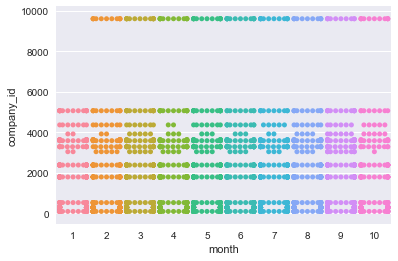

In [433]:
sns.swarmplot(x="month", y="company_id", data=data);

## Homework

- [x] Get time delta
- [x] Merge timedelta into on DF
- [x] Create a test dataset with n=10,000
- [x] Think about what models we want to run through this

## Models to use
**Question: When will the next email be?**

- Linear regression

**Will the next email be a discount?**

- Random forrest (DecisionTreeClassifier)

**How much will they discount by?**

- SVM